# Working Capital Monte Carlo Simulation

This notebook simulates working capital positions under uncertainty to quantify the risk reduction benefits of blockchain-based instant settlement.

## Objectives

1. Model payment timing distributions from industry data
2. Run Monte Carlo simulations for traditional payment system
3. Simulate blockchain system with instant settlement
4. Calculate risk metrics (VaR, CVaR, max drawdown)
5. Compare risk profiles: traditional vs blockchain


In [ ]:
import sys

sys.path.insert(0, "..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from src.utils import extract_10k_metrics, format_currency
from src.working_capital import (
    SimulationParams,
    WorkingCapitalSimulator,
    calculate_risk_reduction,
)

# Plot styling
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 11
np.random.seed(42)

## 1. Payment Timing Distributions

Model the uncertainty in payment timing based on industry data.


In [2]:
# Load 10-K metrics for baseline
metrics = extract_10k_metrics(2024)

# Initialize simulation parameters
params = SimulationParams(
    n_simulations=5_000,
    simulation_days=365,
    loads_per_day=int(metrics["shipments_handled"] / 365),
    shipper_payment_mean=metrics["dso"],
    shipper_payment_std=15.0,  # Industry variation
    carrier_payment_mean=metrics["dpo"],
    carrier_payment_std=5.0,
    revenue_per_load_mean=metrics["revenue_per_load"],
    revenue_per_load_std=500.0,
    blockchain_settlement_days=0.5,
    random_seed=42,
)

print("Simulation Parameters")
print("=" * 50)
print(f"Number of simulations: {params.n_simulations:,}")
print(f"Simulation period: {params.simulation_days} days")
print(f"Loads per day: {params.loads_per_day:,}")
print(
    f"Revenue per load: ${params.revenue_per_load_mean:,.0f} (±${params.revenue_per_load_std:.0f})"
)
print(
    f"\nShipper Payment (DSO): {params.shipper_payment_mean:.0f} days (±{params.shipper_payment_std:.0f})"
)
print(
    f"Carrier Payment (DPO): {params.carrier_payment_mean:.0f} days (±{params.carrier_payment_std:.0f})"
)
print(f"Blockchain Settlement: {params.blockchain_settlement_days} days")

Simulation Parameters
Number of simulations: 5,000
Simulation period: 365 days
Loads per day: 43,013
Revenue per load: $1,127 (±$500)

Shipper Payment (DSO): 49 days (±15)
Carrier Payment (DPO): 27 days (±5)
Blockchain Settlement: 0.5 days


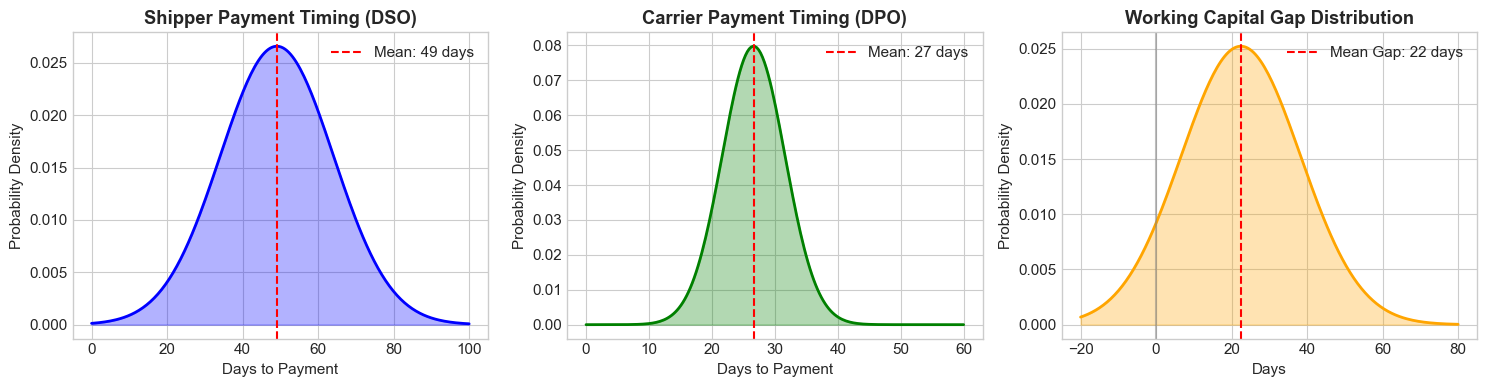

In [ ]:
# Visualize payment timing distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Shipper payment distribution
x_shipper = np.linspace(0, 100, 200)
y_shipper = stats.norm.pdf(
    x_shipper, params.shipper_payment_mean, params.shipper_payment_std
)
axes[0].fill_between(x_shipper, y_shipper, alpha=0.3, color="blue")
axes[0].plot(x_shipper, y_shipper, "b-", linewidth=2)
axes[0].axvline(
    params.shipper_payment_mean,
    color="red",
    linestyle="--",
    label=f"Mean: {params.shipper_payment_mean:.0f} days",
)
axes[0].set_xlabel("Days to Payment")
axes[0].set_ylabel("Probability Density")
axes[0].set_title("Shipper Payment Timing (DSO)", fontweight="bold")
axes[0].legend()

# Carrier payment distribution
x_carrier = np.linspace(0, 60, 200)
y_carrier = stats.norm.pdf(
    x_carrier, params.carrier_payment_mean, params.carrier_payment_std
)
axes[1].fill_between(x_carrier, y_carrier, alpha=0.3, color="green")
axes[1].plot(x_carrier, y_carrier, "g-", linewidth=2)
axes[1].axvline(
    params.carrier_payment_mean,
    color="red",
    linestyle="--",
    label=f"Mean: {params.carrier_payment_mean:.0f} days",
)
axes[1].set_xlabel("Days to Payment")
axes[1].set_ylabel("Probability Density")
axes[1].set_title("Carrier Payment Timing (DPO)", fontweight="bold")
axes[1].legend()

# Working capital gap distribution
gap_mean = params.shipper_payment_mean - params.carrier_payment_mean
gap_std = np.sqrt(params.shipper_payment_std**2 + params.carrier_payment_std**2)
x_gap = np.linspace(-20, 80, 200)
y_gap = stats.norm.pdf(x_gap, gap_mean, gap_std)
axes[2].fill_between(x_gap, y_gap, alpha=0.3, color="orange")
axes[2].plot(x_gap, y_gap, color="orange", linewidth=2)
axes[2].axvline(
    gap_mean, color="red", linestyle="--", label=f"Mean Gap: {gap_mean:.0f} days"
)
axes[2].axvline(0, color="gray", linestyle="-", alpha=0.5)
axes[2].set_xlabel("Days")
axes[2].set_ylabel("Probability Density")
axes[2].set_title("Working Capital Gap Distribution", fontweight="bold")
axes[2].legend()

plt.tight_layout()
plt.savefig("results/figures", dpi=150, bbox_inches="tight")
plt.show()

## 2. Traditional System Simulation

Run Monte Carlo simulation for the traditional payment system.


In [5]:
# Initialize simulator
simulator = WorkingCapitalSimulator(params)

# Run traditional simulation
print("Running Traditional System Simulation...")
traditional_results = simulator.run_monte_carlo(use_fast=True)

print("\nTraditional System Risk Metrics")
print("=" * 50)
summary = traditional_results.summary()
for metric, value in summary.items():
    print(f"{metric.replace('_', ' ').title():30s}: {format_currency(value)}")

Running Traditional System Simulation...

Traditional System Risk Metrics
Mean Daily Position           : $129.2M
Std Daily Position            : $10.1M
Var 95                        : $178.4M
Var 99                        : $184.4M
Cvar 95                       : $181.9M
Max Drawdown                  : $43.6M
Peak Capital Required         : $178.4M


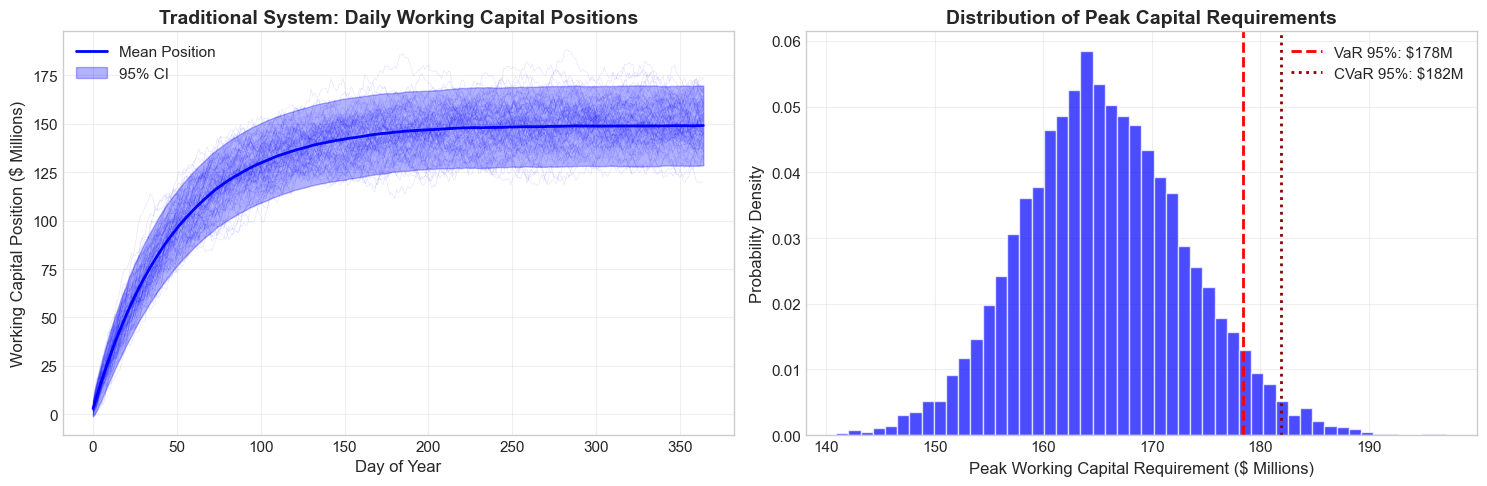

In [8]:
# Visualize simulation paths (spaghetti plot)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Sample paths
n_paths_to_show = 100
days = np.arange(params.simulation_days)

for i in range(n_paths_to_show):
    axes[0].plot(
        days,
        traditional_results.daily_positions[i] / 1e6,
        alpha=0.1,
        color="blue",
        linewidth=0.5,
    )

# Mean and confidence bands
axes[0].plot(
    days,
    traditional_results.mean_position / 1e6,
    "b-",
    linewidth=2,
    label="Mean Position",
)
axes[0].fill_between(
    days,
    (traditional_results.mean_position - 1.96 * traditional_results.std_position) / 1e6,
    (traditional_results.mean_position + 1.96 * traditional_results.std_position) / 1e6,
    alpha=0.3,
    color="blue",
    label="95% CI",
)

axes[0].set_xlabel("Day of Year", fontsize=12)
axes[0].set_ylabel("Working Capital Position ($ Millions)", fontsize=12)
axes[0].set_title(
    "Traditional System: Daily Working Capital Positions",
    fontsize=14,
    fontweight="bold",
)
axes[0].legend(loc="upper left")
axes[0].grid(True, alpha=0.3)

# Distribution of peak positions
peak_positions = np.max(traditional_results.daily_positions, axis=1) / 1e6
axes[1].hist(
    peak_positions, bins=50, density=True, alpha=0.7, color="blue", edgecolor="white"
)
axes[1].axvline(
    traditional_results.var_95 / 1e6,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"VaR 95%: ${traditional_results.var_95 / 1e6:.0f}M",
)
axes[1].axvline(
    traditional_results.cvar_95 / 1e6,
    color="darkred",
    linestyle=":",
    linewidth=2,
    label=f"CVaR 95%: ${traditional_results.cvar_95 / 1e6:.0f}M",
)

axes[1].set_xlabel("Peak Working Capital Requirement ($ Millions)", fontsize=12)
axes[1].set_ylabel("Probability Density", fontsize=12)
axes[1].set_title(
    "Distribution of Peak Capital Requirements", fontsize=14, fontweight="bold"
)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("results/figures", dpi=150, bbox_inches="tight")
plt.show()

## 3. Blockchain System Simulation

Simulate working capital with partial blockchain adoption.


In [9]:
# Run comparative simulation across adoption rates
print("Running Comparative Simulations...")
adoption_rates = [0.0, 0.10, 0.30, 0.50, 0.75, 1.0]
comparative_results = simulator.run_comparative_simulation(adoption_rates)

# Summary table
comparison_data = []
for rate_key, results in comparative_results.items():
    summary = results.summary()
    comparison_data.append(
        {
            "Adoption Rate": rate_key,
            "Mean Position ($M)": summary["mean_daily_position"] / 1e6,
            "VaR 95% ($M)": summary["var_95"] / 1e6,
            "CVaR 95% ($M)": summary["cvar_95"] / 1e6,
            "Peak Capital ($M)": summary["peak_capital_required"] / 1e6,
        }
    )

comparison_df = pd.DataFrame(comparison_data)
print("\nRisk Metrics by Adoption Rate")
print("=" * 70)
comparison_df.round(1)

Running Comparative Simulations...

Risk Metrics by Adoption Rate


,Adoption Rate,Mean Position ($M),VaR 95% ($M),CVaR 95% ($M),Peak Capital ($M)
0,0%,129.2,178.2,181.9,178.2
1,10%,116.2,160.5,163.9,160.5
2,30%,90.4,125.0,127.5,125.0
3,50%,64.5,89.1,91.0,89.1
4,75%,32.3,44.6,45.5,44.6
5,100%,0.0,0.0,0.0,0.0


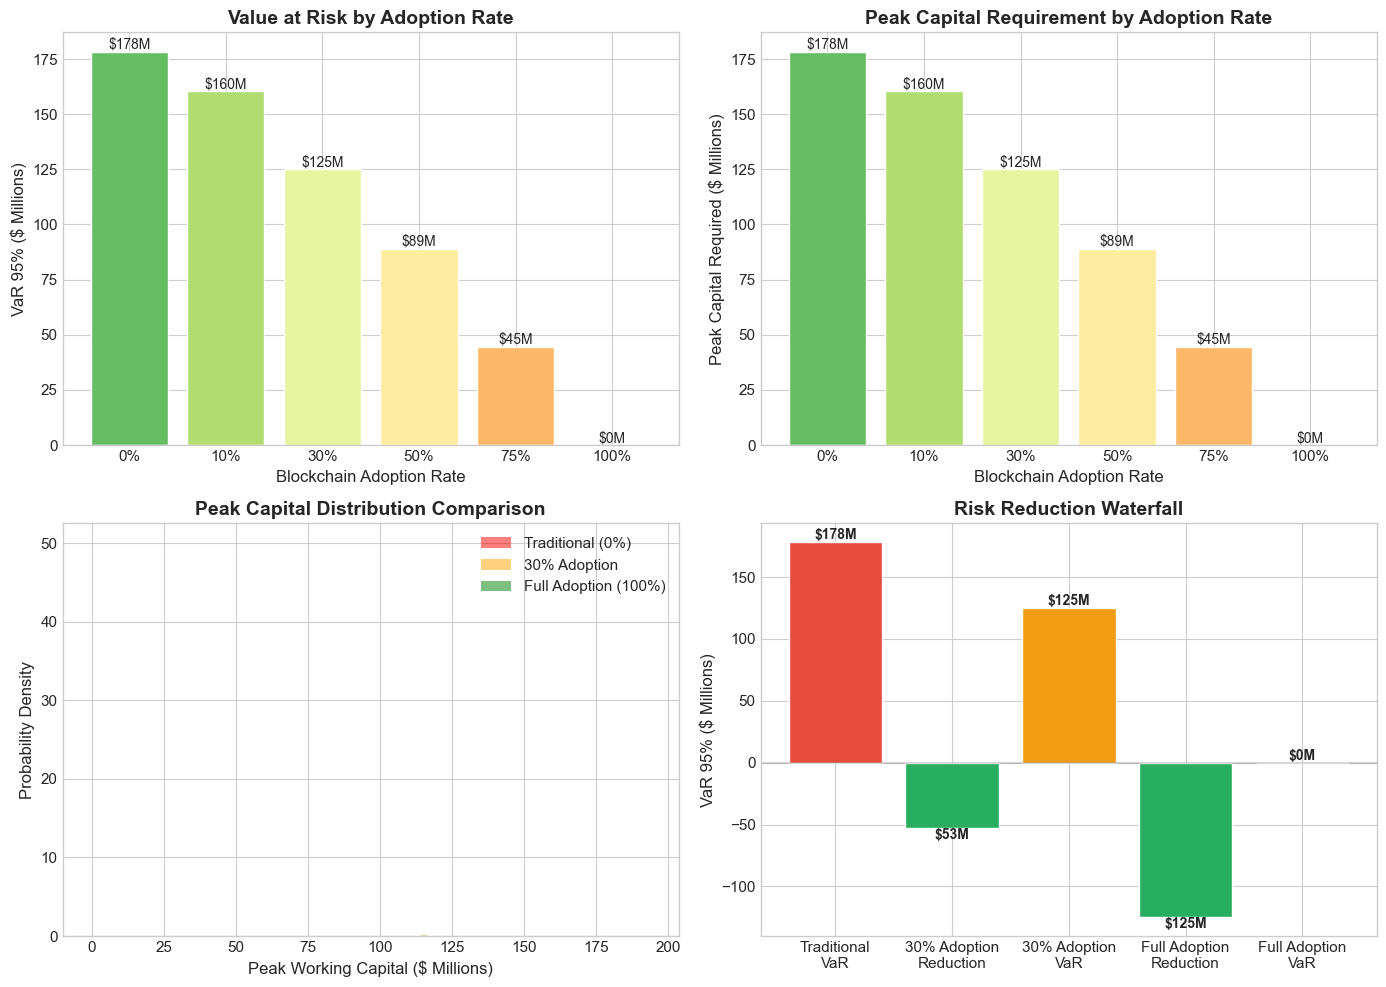

In [11]:
# Visualize comparative results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# VaR comparison
vars_list = [comparative_results[f"{r:.0%}"].var_95 / 1e6 for r in adoption_rates]
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(adoption_rates)))
bars = axes[0, 0].bar(
    [f"{r:.0%}" for r in adoption_rates], vars_list, color=colors, edgecolor="white"
)
axes[0, 0].set_xlabel("Blockchain Adoption Rate", fontsize=12)
axes[0, 0].set_ylabel("VaR 95% ($ Millions)", fontsize=12)
axes[0, 0].set_title("Value at Risk by Adoption Rate", fontsize=14, fontweight="bold")
for bar, val in zip(bars, vars_list):
    axes[0, 0].annotate(
        f"${val:.0f}M",
        xy=(bar.get_x() + bar.get_width() / 2, val),
        ha="center",
        va="bottom",
        fontsize=10,
    )

# Peak capital comparison
peaks = [
    comparative_results[f"{r:.0%}"].peak_capital_required / 1e6 for r in adoption_rates
]
bars = axes[0, 1].bar(
    [f"{r:.0%}" for r in adoption_rates], peaks, color=colors, edgecolor="white"
)
axes[0, 1].set_xlabel("Blockchain Adoption Rate", fontsize=12)
axes[0, 1].set_ylabel("Peak Capital Required ($ Millions)", fontsize=12)
axes[0, 1].set_title(
    "Peak Capital Requirement by Adoption Rate", fontsize=14, fontweight="bold"
)
for bar, val in zip(bars, peaks):
    axes[0, 1].annotate(
        f"${val:.0f}M",
        xy=(bar.get_x() + bar.get_width() / 2, val),
        ha="center",
        va="bottom",
        fontsize=10,
    )

# Distribution comparison (0% vs 30% vs 100%)
for rate, color, label in [
    (0.0, "red", "Traditional (0%)"),
    (0.30, "orange", "30% Adoption"),
    (1.0, "green", "Full Adoption (100%)"),
]:
    peaks_dist = (
        np.max(comparative_results[f"{rate:.0%}"].daily_positions, axis=1) / 1e6
    )
    axes[1, 0].hist(
        peaks_dist, bins=50, density=True, alpha=0.5, color=color, label=label
    )

axes[1, 0].set_xlabel("Peak Working Capital ($ Millions)", fontsize=12)
axes[1, 0].set_ylabel("Probability Density", fontsize=12)
axes[1, 0].set_title(
    "Peak Capital Distribution Comparison", fontsize=14, fontweight="bold"
)
axes[1, 0].legend()

# Risk reduction waterfall
trad_var = comparative_results["0%"].var_95
bc30_var = comparative_results["30%"].var_95
bc100_var = comparative_results["100%"].var_95

categories = [
    "Traditional\nVaR",
    "30% Adoption\nReduction",
    "30% Adoption\nVaR",
    "Full Adoption\nReduction",
    "Full Adoption\nVaR",
]
values = [
    trad_var / 1e6,
    -(trad_var - bc30_var) / 1e6,
    bc30_var / 1e6,
    -(bc30_var - bc100_var) / 1e6,
    bc100_var / 1e6,
]
bar_colors = ["#e74c3c", "#27ae60", "#f39c12", "#27ae60", "#27ae60"]

bars = axes[1, 1].bar(categories, values, color=bar_colors, edgecolor="white")
axes[1, 1].set_ylabel("VaR 95% ($ Millions)", fontsize=12)
axes[1, 1].set_title("Risk Reduction Waterfall", fontsize=14, fontweight="bold")
axes[1, 1].axhline(y=0, color="gray", linestyle="-", alpha=0.3)

for bar, val in zip(bars, values):
    va = "bottom" if val >= 0 else "top"
    axes[1, 1].annotate(
        f"${abs(val):.0f}M",
        xy=(bar.get_x() + bar.get_width() / 2, val),
        ha="center",
        va=va,
        fontsize=10,
        fontweight="bold",
    )

plt.tight_layout()
plt.savefig("results/figures", dpi=150, bbox_inches="tight")
plt.show()

## 4. Risk Metrics Analysis


In [12]:
# Calculate risk reduction metrics
trad_results = comparative_results["0%"]
bc30_results = comparative_results["30%"]
bc100_results = comparative_results["100%"]

risk_reduction_30 = calculate_risk_reduction(trad_results, bc30_results)
risk_reduction_100 = calculate_risk_reduction(trad_results, bc100_results)

print("Risk Reduction Analysis")
print("=" * 60)

print("\n30% Blockchain Adoption:")
for metric, value in risk_reduction_30.items():
    if "pct" in metric:
        print(f"  {metric.replace('_', ' ').title():35s}: {value:.1f}%")
    else:
        print(f"  {metric.replace('_', ' ').title():35s}: {format_currency(value)}")

print("\n100% Blockchain Adoption:")
for metric, value in risk_reduction_100.items():
    if "pct" in metric:
        print(f"  {metric.replace('_', ' ').title():35s}: {value:.1f}%")
    else:
        print(f"  {metric.replace('_', ' ').title():35s}: {format_currency(value)}")

Risk Reduction Analysis

30% Blockchain Adoption:
  Var 95 Reduction                   : $53.2M
  Var 95 Reduction Pct               : 29.8%
  Cvar 95 Reduction                  : $54.4M
  Peak Capital Reduction             : $53.2M
  Volatility Reduction               : $3.0M

100% Blockchain Adoption:
  Var 95 Reduction                   : $178.2M
  Var 95 Reduction Pct               : 100.0%
  Cvar 95 Reduction                  : $181.9M
  Peak Capital Reduction             : $178.2M
  Volatility Reduction               : $10.1M


## 5. Key Findings Summary


In [13]:
print("\n" + "=" * 70)
print("KEY FINDINGS: Working Capital Simulation")
print("=" * 70)

print("\n1. TRADITIONAL SYSTEM RISK PROFILE")
print(
    f"   - Mean Daily Position: {format_currency(trad_results.summary()['mean_daily_position'])}"
)
print(
    f"   - VaR (95%): {format_currency(trad_results.var_95)} - Maximum loss in 95% of scenarios"
)
print(
    f"   - CVaR (95%): {format_currency(trad_results.cvar_95)} - Expected loss in worst 5%"
)
print(
    f"   - Peak Capital Required: {format_currency(trad_results.peak_capital_required)}"
)

print("\n2. BLOCKCHAIN IMPACT (30% Adoption)")
print(
    f"   - VaR Reduction: {format_currency(risk_reduction_30['var_95_reduction'])} ({risk_reduction_30['var_95_reduction_pct']:.1f}%)"
)
print(
    f"   - Peak Capital Reduction: {format_currency(risk_reduction_30['peak_capital_reduction'])}"
)
print(
    f"   - Volatility Reduction: {format_currency(risk_reduction_30['volatility_reduction'])}"
)

print("\n3. FULL BLOCKCHAIN ADOPTION (100%)")
print(
    f"   - VaR Reduction: {format_currency(risk_reduction_100['var_95_reduction'])} ({risk_reduction_100['var_95_reduction_pct']:.1f}%)"
)
print(
    f"   - Peak Capital Reduction: {format_currency(risk_reduction_100['peak_capital_reduction'])}"
)
print(
    f"   - Volatility Reduction: {format_currency(risk_reduction_100['volatility_reduction'])}"
)

print("\n4. CONCLUSION")
print(
    "   Blockchain-based instant settlement significantly reduces working capital risk."
)
print(
    f"   At 30% adoption, peak capital requirements drop by {risk_reduction_30['var_95_reduction_pct']:.0f}%,"
)
print("   freeing up capital for other business uses and reducing financing costs.")
print("\n" + "=" * 70)


KEY FINDINGS: Working Capital Simulation

1. TRADITIONAL SYSTEM RISK PROFILE
   - Mean Daily Position: $129.2M
   - VaR (95%): $178.2M - Maximum loss in 95% of scenarios
   - CVaR (95%): $181.9M - Expected loss in worst 5%
   - Peak Capital Required: $178.2M

2. BLOCKCHAIN IMPACT (30% Adoption)
   - VaR Reduction: $53.2M (29.8%)
   - Peak Capital Reduction: $53.2M
   - Volatility Reduction: $3.0M

3. FULL BLOCKCHAIN ADOPTION (100%)
   - VaR Reduction: $178.2M (100.0%)
   - Peak Capital Reduction: $178.2M
   - Volatility Reduction: $10.1M

4. CONCLUSION
   Blockchain-based instant settlement significantly reduces working capital risk.
   At 30% adoption, peak capital requirements drop by 30%,
   freeing up capital for other business uses and reducing financing costs.

